In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import os
from dl import queryClient as qc
from astropy.table import Table, vstack
import utils

C:\Users\kylem\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kylem\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\kylem\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
from collections import Counter

In [3]:
pltdir = 'results/plots'
if not os.path.exists(pltdir):
    os.makedirs(pltdir)

In [4]:
os.getcwd()

'D:\\msu\\DavidNidever\\TempletFit'

In [5]:
gldrrab = np.loadtxt('goldsample/golden_RRab.txt',delimiter=',',dtype=str)
gldall  = np.loadtxt('goldsample/all_gold_sample.txt',dtype=str)
gldelse = np.array(list(set(gldall) - set(gldrrab)))

In [6]:
import psearch_py3
from scipy.signal import find_peaks, peak_prominences

def get_data(objname, bands = ['u','g','r','i','z','Y','VR']):
    """Query the object by name, extract light curves, 
       error, filters and top N estimated periods."""
    df=qc.query(sql="""SELECT meas.* FROM nsc_dr2.meas
                     WHERE objectid='{:s}'""".format(objname),
              fmt='pandas')
    
    selbnds = [i for i, val in enumerate(df['filter']) if val in bands]
    selfwhm = np.where(df['fwhm'] <= 4.0)[0]
    sel = [x for x in selbnds if x in selfwhm]

    crvdat           = Table([df['mjd'][sel]],names=['mjd'])
    crvdat['mag']    = df['mag_auto'][sel]
    crvdat['err']    = df['magerr_auto'][sel]
    crvdat['fltr']   = -1
    for i in range(len(crvdat)):
        crvdat['fltr'][i] = bands.index(df['filter'][sel[i]])
    crvdat.sort(['fltr','mjd'])
    
    return crvdat

def get_periods(mjd,mag,err,fltr,objname='',N = 5,pmin=.2,bands=['u','g','r','i','z','Y','VR']):
    
    # The filter information here uses indices determined from the order they
    # appear in bands. To run psearch we want to reassign these indices to remove
    # any unused bands. For example, if only 'g', 'r' and 'z' are used, indices
    # should be 0,1,2 and not 1,2,4.
    cnt  = Counter(fltr)
    
    mult = np.where(np.array(list(cnt.values()))>1)[0]
    sel  = np.in1d(fltr, mult)
    
    fltinds = list(set(fltr))
    replace = {fltinds[i]:i for i in range(len(fltinds))}
    newinds = np.array([replace.get(n,n) for n in fltr],dtype=np.float64)
    fltrnms = (np.array(bands))[list(set(fltr[sel]))]
    
    dphi = 0.02
    plist, psiarray, thresh = \
            psearch_py3.psearch_py( mjd[sel], mag[sel], err[sel], 
                                   newinds[sel], fltrnms, pmin, dphi )
    
    psi = psiarray.sum(0)
    
    pkinds = find_peaks(psi,distance=len(plist)/2000)[0]
    prom   = peak_prominences(psi,pkinds)[0]
    inds0  = pkinds[np.argsort(-prom)[:10*N]]
    inds   = inds0[np.argsort(-psi[inds0])[:N]]
    
    plot_periodogram(plist,psi,inds,objname)
    
    return plist[inds]

def plot_periodogram(prds,psi,inds,objname='',outdir='results/plots'):
   
    fig, ax = plt.subplots(figsize=(10,7))
        
    ax.plot(prds,psi,lw=0.1)
    ax.scatter(prds[inds[1:]],psi[inds[1:]],c='k',s=10)
    ax.scatter(prds[inds[0]],psi[inds[0]],c='r',s=12)
    
    ax.set_xlabel('log period (days)',fontsize=18)
    ax.set_ylabel('psi',fontsize=18)
    ax.set_title('{} Periodogram'.format(objname),fontsize=20)
    ax.set_xscale('log')
    ax.text(0.7,0.9,'best period = {:.3f} days'.format(prds[inds[0]]),transform=ax.transAxes,color='r')
    
#     fig.savefig(outdir+'\\{}_periodogram.png'.format(objname))
    
    # create zoomed in copy
    ax.set_title('{} Periodogram Zoomed In'.format(objname),fontsize=20)
    minp = min(prds[inds])
    maxp = max(prds[inds])
    ax.set_xlim(minp*.67,maxp*1.33)
    fig.savefig(outdir+'\\{}_periodogram_zoomedin.png'.format(objname))
    
    plt.close(fig)
    return

In [7]:
def get_data_pix(pix, bands=['u','g','r','i','z','Y','VR']):
    res=qc.query(sql="""SELECT meas.mjd,mag_auto,magerr_auto,objectid,filter,meas.fwhm
                    FROM nsc_dr2.meas JOIN nsc_dr2.object ON meas.objectid=object.id 
                    WHERE pix={:d} and variable10sig=1 and ndet>=30""".format(pix),
                 fmt='table')
    
    selbnds = [i for i, val in enumerate(res['filter']) if val in bands]
    selfwhm = np.where(res['fwhm'] <= 8.0)[0]
    sel = [x for x in selbnds if x in selfwhm]
    
    res['fltr']   = -1
    for i in sel:
        res['fltr'][i] = bands.index(res['filter'][i])
    
    res.rename_column('mag_auto', 'mag')
    res.rename_column('magerr_auto', 'err')
    res.sort(['objectid','fltr','mjd'])
    
    return res[res['fltr']>=0]

In [8]:
data = get_data_pix(100047)
objlist = list(set(data['objectid']))
i = 9
sel = data['objectid'] == objlist[i]
datasel = data[sel]
get_periods(datasel['mjd'],datasel['mag'],datasel['err'],datasel['fltr'],objname=objlist[i])

array([0.57757254, 0.36538759, 0.26694456, 0.36475376, 3.48602152])

In [9]:
class RRLfitter:
    def __init__ (self, tmps, fltnames= ['u','g','r','i','z','Y','VR'], ampratio=[1.81480451,1.46104910,1.0,0.79662171,0.74671563,0.718746,1.050782]):
        # constants
        self.tmps     = tmps # Table containing templates
        self.fltnames = fltnames # list of names of usable filters
        self.Nflts    = len(fltnames) # number of usable filters
        self.ampratio = np.array(ampratio)
        # model variables
        self.fltinds  = [] # list of filter index values (0:'u', 1:'g', etc.)
        self.tmpind   = 1 # index of template currently being used 1,2,...,N
        self.period   = 1
        
    def model(self, t, *args):
        """modify the template using peak-to-peak amplitude and yoffset
        input times t should be epoch folded, phase shift to match template"""
        t0 = args[0]
        amplist = (args[1] * self.ampratio)[self.fltinds]
        yofflist = np.array(args[2:])[self.fltinds]
        
        ph = (t - t0) / self.period %1
        template = interp1d(self.tmps.columns[0],self.tmps.columns[self.tmpind])(ph)
        
        mag = template * amplist + yofflist
        
        return mag

    def tmpfit(self,mjd,mag,err,fltinds,plist,initpars=None):
        self.fltinds = fltinds
        if isinstance(plist, (int,float)):
            plist = [plist]
        
        
        if initpars is None:
            initpars = np.zeros( 2 + self.Nflts )
            initpars[0]  = min(mjd)
            initpars[2:] = np.median(mag)
            ampest = []
            for f in set(fltinds):
                ampest.append( (max(mag[fltinds==f])-min(mag[fltinds==f]))/self.ampratio[f] )
            initpars[1]  = np.mean(ampest)

        bounds = ( np.zeros(2+self.Nflts), np.zeros(2+self.Nflts))
        bounds[0][0] =  0.0
        bounds[1][0] = np.inf
        bounds[0][1] =  0.0
        bounds[1][1] = 50.0
        bounds[0][2:]=-50.0
        bounds[1][2:]= 50.0

        for i in set(range(self.Nflts))-set(self.fltinds):
            initpars[2+i]  =   0
            bounds[0][2+i] = -10**-6
            bounds[1][2+i] =  10**-6
        
        minx2    = 2**99
        bestpars = np.zeros( 2 + self.Nflts )
        besttmp  =-1
        besterr  = 0
        bestprd  = 0
        for p in plist:
            self.period = p
            
            for n in range(1,len(self.tmps.columns)):
                self.tmpind = n
                
                try:
                    pars, cov = curve_fit(self.model, mjd, mag, 
                                          bounds=bounds, sigma=err,
                                          p0=initpars, maxfev=5000)
                except RuntimeError:
                    continue
                x2 = sum((self.model(mjd,*pars)-mag)**2/err**2)
                if x2 < minx2:
                    minx2 = x2
                    bestpars = pars
                    besterr = np.sqrt(np.diag(cov))
                    bestprd = p
                    besttmp = n
                    
        self.period = bestprd
        self.tmpind = besttmp
        
        return bestpars, bestprd, besterr, besttmp, minx2

    def fit_plot(self,objname,N=10):
        crvdat = get_data(objname,bands=self.fltnames)
        
        plist  = get_periods(crvdat['mjd'],crvdat['mag'],crvdat['err'],crvdat['fltr'],
                             objname=objname,bands=self.fltnames,N=10)

        # Fit curve
        pars,p,err,tmpind,chi2 = self.tmpfit(crvdat['mjd'],crvdat['mag'],crvdat['err'],crvdat['fltr'],plist)
        
        # Reject outliers, select inliers
        resid   = np.array(abs(crvdat['mag']-self.model(crvdat['mjd'],*pars)))
        crvdat['inlier'] = resid<utils.mad(resid)*5
        
        # Fit with inliers only
        pars,p,err,tmpind,chi2 = self.tmpfit(crvdat['mjd'][crvdat['inlier']],crvdat['mag'][crvdat['inlier']],
                                             crvdat['err'][crvdat['inlier']],crvdat['fltr'][crvdat['inlier']],plist,pars)
        
        redchi2 = chi2/(sum(crvdat['inlier'])-len(set(crvdat['fltr'][crvdat['inlier']]))-2)
        
        # get the filters with inlier data (incase it's different from all data)
        inlierflts = set(crvdat['fltr'][crvdat['inlier']])
        # Add phase to crvdat and sort
        crvdat['ph'] = ph = (crvdat['mjd'] - pars[0]) / p %1
        crvdat.sort(['fltr','ph'])
        self.fltinds = crvdat['fltr']
        
        # Plot
        colors  = ['#1f77b4','#2ca02c','#d62728','#9467bd','#8c564b','y','k']
        nf      = len(inlierflts) # Number of filters with inliers
        fig, ax = plt.subplots(nf, figsize=(12,4*(nf**.75+1)), sharex=True)
        if nf == 1:
            ax  = [ax]
        
        for i,f in enumerate(inlierflts):
            sel = crvdat['fltr'] == f
            ax[i].scatter(crvdat['ph'][sel],crvdat['mag'][sel],c=colors[f])
            ax[i].scatter(crvdat['ph'][sel]+1,crvdat['mag'][sel],c=colors[f])
            tmpmag = np.tile(self.tmps.columns[tmpind]*pars[1]*self.ampratio[f]+pars[2:][f],2)
            tmpph  = np.tile(self.tmps['PH'],2)+([0]*len(self.tmps['PH'])+[1]*len(self.tmps['PH']))
            ax[i].plot(tmpph,tmpmag,c='k')
            ax[i].invert_yaxis()
            ax[i].set_ylabel(self.fltnames[f], fontsize=20)
        
        ax[-1].set_xlabel('Phase', fontsize=20)
        ax[0].set_title("Object: {}    Period: {:.3f} d    Type: {}".format(
                                            objname,p,self.tmps.colnames[tmpind]), fontsize=22)
        fig.savefig('results/plots/{}_plot.png'.format(objname))
        plt.close(fig)
        
        # save parameters and results
        res = Table([[objname]],names=['name'])
        res['period'] = p
        res['t0']     = pars[0]
        res['r amp']  = pars[1]
        for i in range(2,len(pars)):
            f = self.fltnames[i-2]
            res['{} mag'.format(f)] = pars[i]
        res['chi2']   = chi2
        res['redchi2']= redchi2
        res['template']= self.tmps.colnames[tmpind]
        res['t0 err']     = err[0]
        res['amp err']  = err[1]
        for i in range(2,len(err)):
            f = self.fltnames[i-2]
            res['{} mag err'.format(f)] = err[i]
        res['Ndat']      = len(crvdat)
        res['N inliers'] = sum(crvdat['inlier'])
        for i in range(len(self.fltnames)):
            f = self.fltnames[i]
            res['N {}'.format(f)] = sum(crvdat['fltr'][crvdat['inlier']]==i)
        res.write('results/{}_res.fits'.format(objname),format='fits',overwrite=True)
        
        return
        
tmps = Table.read('templates/layden_templates.fits',format='fits')['PH','RRA1','RRA2','RRA3','RRB1','RRB2','RRB3','RRC']
fitter  = RRLfitter(tmps,['u','g','r','i','z','Y','VR'],[1.8148,1.4610,1.0,0.7966,0.7467,0.7187,1.0507])

In [50]:
fitter.fit_plot('97486_430')

In [10]:
def fit_plot_pix(pix):
    alldat = get_data_pix(pix,bands=fitter.fltnames)
    
    objs = set(alldat['objectid'])
    
    for objname in objs:
        print(objname)
        selobj = alldat['objectid'] == objname
        crvdat = alldat[selobj]
        
        plist  = get_periods(crvdat['mjd'],crvdat['mag'],crvdat['err'],crvdat['fltr'],
                             objname=objname,bands=fitter.fltnames,N=10)

        # Fit curve
        pars,p,err,tmpind,chi2 = fitter.tmpfit(crvdat['mjd'],crvdat['mag'],crvdat['err'],crvdat['fltr'],plist)

        # Reject outliers, select inliers
        resid   = np.array(abs(crvdat['mag']-fitter.model(crvdat['mjd'],*pars)))
        crvdat['inlier'] = resid<utils.mad(resid)*5

        # Fit with inliers only
        pars,p,err,tmpind,chi2 = fitter.tmpfit(crvdat['mjd'][crvdat['inlier']],crvdat['mag'][crvdat['inlier']],
                                             crvdat['err'][crvdat['inlier']],crvdat['fltr'][crvdat['inlier']],plist,pars)

        redchi2 = chi2/(sum(crvdat['inlier'])-len(set(crvdat['fltr'][crvdat['inlier']]))-2)

        # get the filters with inlier data (incase it's different from all data)
        inlierflts = set(crvdat['fltr'][crvdat['inlier']])
        # Add phase to crvdat and sort
        crvdat['ph'] = ph = (crvdat['mjd'] - pars[0]) / p %1
        crvdat.sort(['fltr','ph'])
        fitter.fltinds = crvdat['fltr']

        # Plot
        colors  = ['#1f77b4','#2ca02c','#d62728','#9467bd','#8c564b','y','k']
        nf      = len(inlierflts) # Number of filters with inliers
        fig, ax = plt.subplots(nf, figsize=(12,4*(nf**.75+1)), sharex=True)
        if nf == 1:
            ax  = [ax]

        for i,f in enumerate(inlierflts):
            sel = crvdat['fltr'] == f
            ax[i].scatter(crvdat['ph'][sel],crvdat['mag'][sel],c=colors[f])
            ax[i].scatter(crvdat['ph'][sel]+1,crvdat['mag'][sel],c=colors[f])
            tmpmag = np.tile(fitter.tmps.columns[tmpind]*pars[1]*fitter.ampratio[f]+pars[2:][f],2)
            tmpph  = np.tile(fitter.tmps['PH'],2)+([0]*len(fitter.tmps['PH'])+[1]*len(fitter.tmps['PH']))
            ax[i].plot(tmpph,tmpmag,c='k')
            ax[i].invert_yaxis()
            ax[i].set_ylabel(fitter.fltnames[f], fontsize=20)

        ax[-1].set_xlabel('Phase', fontsize=20)
        ax[0].set_title("Object: {}    Period: {:.3f} d    Type: {}".format(
                                            objname,p,fitter.tmps.colnames[tmpind]), fontsize=22)
        fig.savefig('results/plots/{}_plot.png'.format(objname))
        plt.close(fig)

        # save parameters and results
        res = Table([[objname]],names=['name'])
        res['period']    = p
        res['t0']        = pars[0]
        res['r amp']     = pars[1]
        for i in range(2,len(pars)):
            f = fitter.fltnames[i-2]
            res['{} mag'.format(f)] = pars[i]
        res['chi2']      = chi2
        res['redchi2']   = redchi2
        res['template']  = fitter.tmps.colnames[tmpind]
        res['t0 err']    = err[0]
        res['amp err']   = err[1]
        for i in range(2,len(err)):
            f = fitter.fltnames[i-2]
            res['{} mag err'.format(f)] = err[i]
        res['Ndat']      = len(crvdat)
        res['N inliers'] = sum(crvdat['inlier'])
        for i in range(len(fitter.fltnames)):
            f = fitter.fltnames[i]
            res['N {}'.format(f)] = sum(crvdat['fltr'][crvdat['inlier']]==i)
        res.write('results/{}_res.fits'.format(objname),format='fits',overwrite=True)

    return

In [11]:
fit_plot_pix(196000)

196000_1748
196000_1577
196000_222
196000_835


In [12]:
fails = []
# for nm in gldrrab[:0]:
#     try:
#         print(nm)
#         print('* * * * * * * * * * *')
#         fitter.fit_plot(nm)
#     except:
#         print('failed on {}'.format(nm))
#         print('+ + + + + + + + + + +')
#         fails.append(nm)
#         continue

In [13]:
fails

[]

['107453_1174',
 '124971_10347',
 '147091_47354',
 '148119_78165',
 '148623_30790',
 '148630_76049',
 '148631_115031',
 '148631_24329',
 '148631_95231',
 '149142_91743',
 '149144_103050',
 '149144_46718',
 '149144_94834',
 '150167_1560',
 '150167_9176',
 '150168_1381',
 '150168_18639',
 '188977_12448',
 '188977_16385',
 '188977_3062',
 '188978_7752']

- - -

In [14]:
objs = []
# for nm in gldrrab:
#     df=qc.query(sql="""SELECT meas.* 
#                  FROM nsc_dr2.meas
#                  WHERE objectid='{:s}'""".format(nm),
#           fmt='pandas')
#     ct = collections.Counter(df['filter'])
#     if ct['Y'] < 40:
#         continue
#     if ct['VR'] < 40:
#         continue
#     print('')
#     print(nm)
#     objs.append(nm)
#     print(ct)

In [15]:
from scipy.optimize import minimize
ratiolist = []
for nm in objs:
    print(nm)
    crvdat,plist = get_data(nm,N=3,bands=['u','g','r','i','z','Y','VR'])
    print(plist)
    def ratios(*pars):
        pars = pars[0]
        fittY.ampratio = np.array([1.81480451,1.46104910,1.0,0.79662171,0.74671563,pars[0],pars[1]])
        pars, p0, err, tmpind, x2 = fittY.tmpfit(crvdat['mjd'],crvdat['mag'],crvdat['err'],crvdat['fltr'],plist[0])
        return x2
    
    minres = minimize(ratios,[[1.,1.]],bounds = [(.1,2),(.1,2)]).x
    
    fittY.ampratio = np.array([1.81480451,1.46104910,1.0,0.79662171,0.74671563,minres[0],minres[1]])
    print(fittY.ampratio)
    ratiolist.append(fittY.ampratio)
    fittY.fit_plot(nm,crvdat,plist)

In [16]:
ratioarray = np.array(ratiolist)

In [17]:
objs

[]

In [19]:
from astropy.table import Table, Column, vstack
from glob import glob
# rows = []
# nms  = []
# for path in glob('results/res7/*.fits'):
#     rows.append(Table.read(path))
#     nms.append(path[13:-9])
# rrlres = vstack(rows)
# rrlres['name'] = Column(nms)
# rrlres.write('rrlres.fits',format='fits',overwrite=True)
# rrlres.sort('redchi2')

In [24]:
rrlres = Table.read('rrlres7.fits')
rrlres

name,period,t0,r amp,u mag,g mag,r mag,i mag,z mag,Y mag,VR mag,chi2,redchi2,template,t0 err,amp err,u mag err,g mag err,r mag err,i mag err,z mag err,Y mag err,VR mag err,Ndat,N inliers,N u,N g,N r,N i,N z,N Y,N VR
bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32
190529_7302,0.4571362393048764,57081.07180144338,0.8010809964760937,-1.7339998864810695e-17,15.216524988265911,15.283975411175444,0.0,0.0,0.0,0.0,15.82547705692911,2.2607824367041585,RRA2,0.0005538077407356206,0.0557799490679122,1.3798174825245658e-17,0.0720461899649508,0.04077148328135636,0.0,0.0,0.0,0.0,11,11,0,2,9,0,0,0,0
147606_91069,0.5925040219947078,56521.357293741494,0.5749527979427688,0.0,18.043054768947677,17.925214874471294,17.81523423155646,0.0,0.0,0.0,432.6899235860861,2.6065658047354585,RRB1,0.0006696612146872268,0.004926268727887342,2.1205069693817753e-17,0.003982670730053196,0.0030003056147854157,0.009542881705153345,0.0,0.0,0.0,175,171,0,83,85,3,0,0,0
147603_46584,0.4817943736899384,56448.21782669492,0.8806319867944428,18.679383620043517,17.769299506081044,17.78674872655439,17.74360932629493,17.691675960556797,17.6240041550375,17.71771262403183,901.502206282231,2.731824867521912,RRA1,0.0019314949135487633,0.011832866686818223,0.03330096563511863,0.01791914666839101,0.012416344980272017,0.010488083478098884,0.009890815573531345,0.02184176994425821,0.013174776623671093,362,339,5,113,127,38,39,4,13
150679_79443,0.5581025678496574,56520.76756945642,0.5405144956694408,0.0,17.7824652114543,17.694528696783028,17.618886896542616,0.0,0.0,0.0,435.3646635094222,2.7554725538571025,RRA2,0.003347375228493094,0.008883987812647086,2.5232295102252212e-18,0.012885433470101813,0.008847373743594586,0.009574222776446895,0.0,0.0,0.0,175,163,0,78,81,4,0,0,0
102849_2399,0.6491950192948136,57040.461986056434,0.2180335791573411,0.0,18.18407757869641,18.12064402447169,0.0,0.0,0.0,0.0,3112.7460743076467,2.7842093687903815,CEPH1,0.000315732012913657,0.001010197119659201,2.892252771167951e-18,0.0009874371878329355,0.007500099731834669,0.0,0.0,0.0,0.0,1132,1122,0,1120,2,0,0,0,0
149656_24078,0.5378294615061243,56520.86429573676,0.7589093973156356,0.0,17.44263614610695,17.487006204844537,0.0,0.0,0.0,0.0,462.20136050189683,2.8183009786701025,RRA1,0.0011170143802050302,0.0063165179317332225,0.0,0.008206465726225624,0.0054025463049765235,0.0,0.0,0.0,0.0,172,168,0,82,86,0,0,0,0
150168_75458,0.5936743182640866,56521.20747745048,0.550483796259212,0.0,17.678396108845472,17.619730516841617,0.0,0.0,0.0,0.0,472.2508134961373,2.9332348664356354,RRB3,0.0005780410837672872,0.0047127929415942136,5.90827276284173e-18,0.004434993405327886,0.0035392886535685025,0.0,0.0,0.0,0.0,171,165,0,83,82,0,0,0,0
148119_49215,0.6247358488858737,56309.519432916415,0.4308654191061588,0.0,18.049095784951852,17.89339644095465,17.76788892207396,0.0,0.0,0.0,500.7099769054488,2.9982633347631666,RRB3,0.0007938180624983878,0.005195816734962046,1.610068304466828e-18,0.004446050105276834,0.003336347672707554,0.0074763753963726295,0.0,0.0,0.0,177,172,0,86,82,4,0,0,0
150167_37094,0.5328271907585349,56520.88021794042,0.4098292641144637,0.0,18.319216317700892,18.13863430060849,18.051250975588975,0.0,0.0,0.0,500.921625001566,3.035888636373127,RRB1,0.0061041454845473676,0.014904404177284029,3.4635697085791113e-18,0.020068243274792244,0.01365270806156413,0.015009293489875699,0.0,0.0,0.0,177,170,0,81,86,3,0,0,0


(0.0, 1.5)

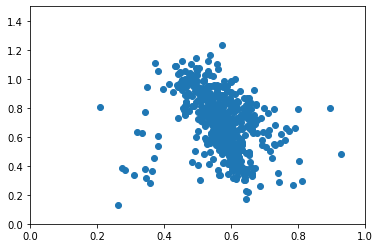

In [48]:
plt.scatter(rrlres['period'],rrlres['r amp'])
plt.xlim(0,1)
plt.ylim(0,1.5)

In [22]:
selVR = rrlres['N VR'] > 30
rrlres[selVR]

name,period,t0,r amp,u mag,g mag,r mag,i mag,z mag,Y mag,VR mag,chi2,redchi2,template,t0 err,amp err,u mag err,g mag err,r mag err,i mag err,z mag err,Y mag err,VR mag err,Ndat,N inliers,N u,N g,N r,N i,N z,N Y,N VR
bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32
171546_6785,0.6372249863442095,56289.16390299379,0.2993625642118835,18.10479098778419,16.98983297537951,16.787469241762775,16.678724234475087,16.63937262944539,16.613004120625433,16.75882708631142,8023.771668251242,7.7674459518405055,CEPH1,0.0006011421327264704,0.0019686676076522166,0.005629564112864447,0.0019228970523596253,0.0015307800916554556,0.0013189154933032944,0.0015083196842338863,0.00293626960860175,0.002328706816094336,1091,1042,334,148,178,113,132,88,49
172435_13102,0.506603196865706,56314.286917177014,0.9389608492368667,16.59001070042093,15.714254471457927,15.778146958784564,15.7452846683167,15.712269340259635,15.701433136156224,15.707436806744587,34061.50787610491,46.53211458484277,RRA1,0.000153314256735398,0.004219406151395039,0.017393367670861852,0.004699912359221891,0.003411419318298699,0.002975787864418354,0.002742300119288309,0.004711327323317108,0.0034539799352197205,755,741,83,113,141,112,118,89,85
144522_34451,0.45338990768432536,56417.431178843675,0.9216942118749547,16.76377953895283,15.65753994477351,15.55796629917714,15.477325554028235,15.34298209680495,15.317884307297149,15.47449544876522,55324.95146350132,67.4694530042699,RRA2,0.00029908526755876213,0.0058363930488664565,0.17652668929848245,0.009616457261731357,0.004399490116443477,0.011159938751825402,0.003347629924448376,0.012818227119759853,0.006201989646658229,830,829,6,37,248,32,387,31,88
146570_154526,0.44234823019389446,56449.33003153448,0.9427130153582807,16.524157460152235,15.43557349295794,15.37536601308362,15.285915081843727,15.189658393039354,15.090620937039086,15.292342022572495,69256.47179566744,77.29516941480742,RRA3,0.00023259667436147796,0.005733861648294853,0.12339953038914758,0.009393155550715123,0.004615908844388857,0.007935555292435803,0.0035988942215964843,0.009894035326532321,0.006320917162398555,911,905,3,43,266,49,409,43,92
145034_183044,0.551990757907491,56417.44134047155,0.7497809661736851,17.335211786076655,16.123940864218657,15.943655314626538,15.793583971682786,15.685946684778612,15.548488280114057,15.872711009200188,44251.9220862554,96.61991721889825,RRA2,0.0006104655868612524,0.008353844171583427,0.22584579603813243,0.010950390681865445,0.005763627928232958,0.01481371842663809,0.006570669108932107,0.018029654278036846,0.010625128024991983,479,467,4,43,227,32,97,31,33
146059_197514,0.5787014640563571,56449.631703073755,0.4938061902957353,17.46879518798571,16.28250326463109,15.930289371256688,15.713377869300588,15.588469528988377,15.540761645933285,15.868785554730879,173317.02700003574,162.13005332089406,RRB3,0.0008846672311970901,0.006431112254164838,0.15507520092405283,0.009517031336897104,0.005201871411187378,0.01308961205302673,0.0039465852912128185,0.014324622601548724,0.006354132967260918,1080,1078,2,55,305,45,495,42,134
145034_148549,0.5450706822314094,56411.66458732385,0.7802946363632562,16.969149066269022,15.497506643148899,15.252672284185854,15.116406047796241,14.972755770324246,14.962870546267075,15.134906332654943,116473.86724302842,184.00294983100855,RRB1,0.0007792184417894122,0.011957100066514004,0.29631904309309537,0.015635413476236024,0.009421195242241871,0.016899898503072105,0.007332306061307617,0.016911435023061586,0.013066905369617722,645,642,4,40,223,36,260,35,44
145546_164189,0.5188631583610767,56448.71136695112,0.9884584295238273,17.36117781939307,16.242437081514474,16.100498576076777,16.031652890758117,15.928614736303452,15.886732266971404,16.026635813724255,389034.7751940572,325.00816641107536,RRA2,0.0005405163492595679,0.011101866062753336,0.2271651094

In [23]:
selVR = rrlres['N Y'] > 30
rrlres[selVR]

name,period,t0,r amp,u mag,g mag,r mag,i mag,z mag,Y mag,VR mag,chi2,redchi2,template,t0 err,amp err,u mag err,g mag err,r mag err,i mag err,z mag err,Y mag err,VR mag err,Ndat,N inliers,N u,N g,N r,N i,N z,N Y,N VR
bytes13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes5,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,int32,int32,int32,int32,int32,int32
167969_743,0.6284231805550854,56395.22514318941,0.36995472681585284,18.120305619294534,17.173231162196636,17.058189637925405,16.880101126875505,16.774970759530255,16.747211136356277,0.0,2014.2277372518404,3.6958307105538357,RRB3,0.0010165141902089049,0.004714365890273633,0.020643462884785514,0.005248907367096022,0.003808448463067855,0.0034205115334395566,0.003261450127952429,0.006606932445609199,0.0,565,553,26,108,114,126,109,70,0
183725_30240,0.5993244402254501,56264.0741584424,0.5581856283945048,0.0,18.77359982970623,18.738988038974636,18.704584308012134,18.684516015100375,18.664223804317118,0.0,7092.42875516294,6.188855807297505,RRB3,0.0005390280988514128,0.004634514305699345,2.078400026850269e-17,0.0055933114698745205,0.003916609470360888,0.004815899845468936,0.0032597669115522004,0.009031368528505236,0.0,1179,1153,0,732,199,48,134,40,0
167488_938,0.6542959517002741,56395.34686208798,0.723225790745535,18.033905269348686,17.546241677094272,17.58681986810332,17.577335356269472,17.607610696712527,17.707171631053992,0.0,3051.300553350809,6.3968565059765385,RRB1,0.001013360290412898,0.012768890330060817,0.05898116956178241,0.013583025572289187,0.010054621340558382,0.008485670780760395,0.00913863681797605,0.02064875332867857,0.0,502,485,10,99,105,113,101,57,0
138265_816,0.45421586886076387,56415.96432556783,0.9487406626733285,19.71693831664214,18.894844919384525,19.059601753436127,19.12496500413199,19.037393406630418,18.905285152126893,18.942822837823897,1187.3596422200785,6.94362363871391,RRA1,0.000737821254073059,0.012691103422512682,0.07264180639185873,0.01839536878782683,0.009499891583134744,0.009175946208471161,0.013708886475099309,0.027017478269486188,0.0155033209045955,187,180,8,18,23,35,37,51,8
171546_6785,0.6372249863442095,56289.16390299379,0.2993625642118835,18.10479098778419,16.98983297537951,16.787469241762775,16.678724234475087,16.63937262944539,16.613004120625433,16.75882708631142,8023.771668251242,7.7674459518405055,CEPH1,0.0006011421327264704,0.0019686676076522166,0.005629564112864447,0.0019228970523596253,0.0015307800916554556,0.0013189154933032944,0.0015083196842338863,0.00293626960860175,0.002328706816094336,1091,1042,334,148,178,113,132,88,49
167863_26731,0.6623726460766448,56331.83531891725,0.6878393373017335,17.56152858467085,16.604802867769823,16.448253179911504,16.31343989575225,16.218568963845055,16.194926941204283,0.0,2320.139822477093,8.286213651703903,RRA2,0.0010173514370733485,0.007158460360426955,0.05688419082534318,0.0077739835893222186,0.005687878657551614,0.005900403202416644,0.00650087826764472,0.011568659631487982,0.0,297,288,12,59,69,62,51,35,0
167864_28471,0.5101346141820886,56332.18310489512,0.8129693765836417,17.103332694581553,16.588849497875103,16.596652922249746,16.576676164292447,16.522487335347197,16.43422762975144,0.0,4286.271845069113,11.873329210717763,RRA3,0.0006411377137240782,0.010428737297792225,0.08714569385087104,0.010794239285327481,0.007298624866295443,0.008072616054774315,0.009156354164426568,0.01539487422979446,0.0,388,369,3,79,74,86,75,52,0
100047_2267,0.6221807486335239,56513.34072455316,0.533098911383821,0.0,17.25899290077619,17.24973794907744,17.25171997828623,17.235351095279217,17.19691110478433,0.0,15535.103358555012,12.967532018827223,RRB1,0.0003926240074182534,0.003728044642727811,4.0684316720778576e-18,0.003674810320180048,0.0028688263237526337,0.0026780045587562556,0.0033722848467393606,0.006463593093220465,0.0,1285,1205,0,253,256,266,234,196,0
166896_20803,0.566159739005946,56342.824263778966,0.579333952219641,17.133